<a href="https://colab.research.google.com/github/nemoiitkgp/FWI-Codes-PhD/blob/main/Anticline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip -q install deepwave scikit-image

Device: cuda
Keys found in .mat file: ['dx', 'dz', 'fmat']
Validated Model shape (nx, nz) = 850 x 404
Velocity range: 1500.0 to 2800.0 m/s


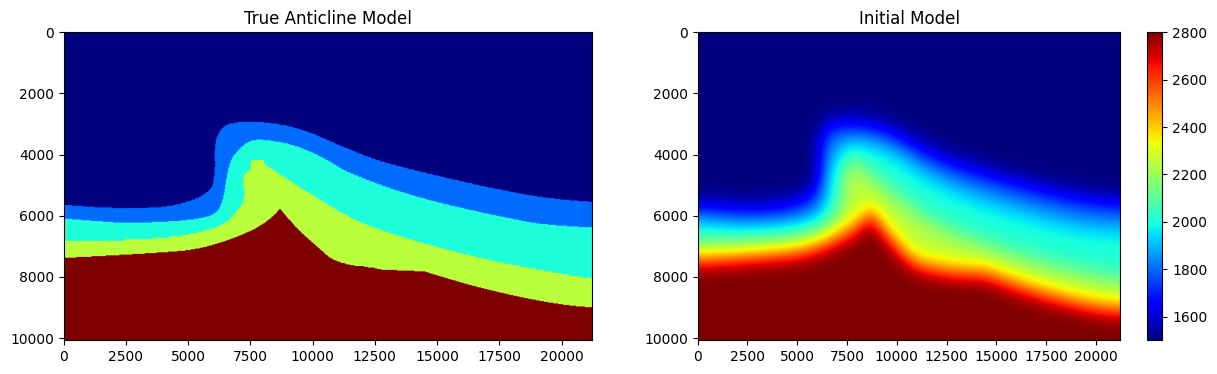

Generating observed data...
Starting Inversion...


OutOfMemoryError: CUDA out of memory. Tried to allocate 8.95 GiB. GPU 0 has a total capacity of 14.56 GiB of which 5.22 GiB is free. Including non-PyTorch memory, this process has 9.34 GiB memory in use. Of the allocated memory 9.17 GiB is allocated by PyTorch, and 59.78 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [5]:
# 1. INSTALL LIBRARIES
!pip install deepwave

# 2. LIBRARIES AND SETTINGS
import numpy as np
import torch
import scipy.io
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import deepwave
from deepwave import scalar

# Device: GPU if available (T4 on Colab)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# 3. INPUT: ANTICLINE MODEL (.mat file)
mat_path = 'anticline_model.mat'

try:
    mat = scipy.io.loadmat(mat_path)
    print("Keys found in .mat file:", [k for k in mat.keys() if "__" not in k])

    # Logic to find the actual velocity array (the largest 2D array)
    v_true_np = None
    max_size = 0
    for key in mat:
        if isinstance(mat[key], np.ndarray):
            # Squeeze to remove dimensions of size 1 (e.g., (187, 801, 1) -> (187, 801))
            arr = np.squeeze(mat[key])
            if arr.ndim == 2 and arr.size > max_size:
                v_true_np = arr.astype(np.float32)
                max_size = arr.size

    if v_true_np is None:
        raise ValueError("Could not find a valid 2D velocity array in the .mat file.")

    # Unit Correction: If values are ~2.0, they are likely km/s. Convert to m/s.
    if np.max(v_true_np) < 10:
        print("Detected velocity in km/s. Converting to m/s...")
        v_true_np *= 1000.0

except FileNotFoundError:
    print(f"Error: {mat_path} not found. Please upload it to the 'Files' tab in Colab.")
    raise

# Convert to torch.
# Deepwave usually expects (nx, nz). If your mat is (nz, nx), transpose it.
v_true = torch.from_numpy(v_true_np).to(device)
if v_true.shape[0] < v_true.shape[1]: # Heuristic: usually width > depth
    v_true = v_true.T

nx, nz = v_true.shape
print(f"Validated Model shape (nx, nz) = {nx} x {nz}")

# Grid spacing
dx, dz = 25.0, 25.0
spacing = (dx, dz)
extent = [0, (nx - 1) * dx, (nz - 1) * dz, 0]

# 4. INITIAL VELOCITY MODEL
v_init = (torch.tensor(1/gaussian_filter(1/v_true.cpu().numpy(), sigma=15)).to(device))
v1 = v_init.clone()
v1.requires_grad_()

vmin_plot, vmax_plot = v_true.min().item(), v_true.max().item()
print(f"Velocity range: {vmin_plot:.1f} to {vmax_plot:.1f} m/s")

# PLOT
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
ax1.imshow(v_true.cpu().T, cmap='jet', aspect='auto', vmin=vmin_plot, vmax=vmax_plot, extent=extent)
ax1.set_title('True Anticline Model')
im2 = ax2.imshow(v1.detach().cpu().T, cmap='jet', aspect='auto', vmin=vmin_plot, vmax=vmax_plot, extent=extent)
ax2.set_title('Initial Model')
plt.colorbar(im2, ax=ax2)
plt.show()

# 5. ACQUISITION GEOMETRY
n_shots = 20
n_sources_per_shot = 1
n_receivers_per_shot = nx # All surface receivers
freq = 5.0
dt = 0.002
nt = 1500
peak_time = 1.5/freq

source_loc = torch.zeros(n_shots, n_sources_per_shot, 2, dtype=torch.long, device=device)
source_loc[..., 1] = 2
source_loc[:, 0, 0] = torch.linspace(0, nx - 1, n_shots).round()

receiver_loc = torch.zeros(n_shots, n_receivers_per_shot, 2, dtype=torch.long, device=device)
receiver_loc[..., 1] = 2
receiver_loc[:, :, 0] = torch.linspace(0, nx - 1, n_receivers_per_shot).round()

source_amp = (deepwave.wavelets.ricker(freq, nt, dt, peak_time)
              .repeat(n_shots, n_sources_per_shot, 1).to(device))

# 6. FORWARD MODELLING (BATTERED)
print("Generating observed data...")
observed_data = torch.zeros(n_shots, n_receivers_per_shot, nt, device=device)
batch_size = 4

with torch.no_grad():
    for i in range(0, n_shots, batch_size):
        out = scalar(v_true, spacing, dt,
                     source_amplitudes=source_amp[i:i+batch_size],
                     source_locations=source_loc[i:i+batch_size],
                     receiver_locations=receiver_loc[i:i+batch_size],
                     accuracy=4, pml_freq=freq)
        observed_data[i:i+batch_size] = out[-1]
        torch.cuda.empty_cache()

# 7. INVERSION
def taper(x): return deepwave.common.cosine_taper_end(x, 15)
observed_data_tapered = taper(observed_data)
loss_fn = torch.nn.MSELoss()
optimiser = torch.optim.Adam([v1], lr=15.0)

print("Starting Inversion...")
for epoch in range(600): # 600 iterations for a good balance of time/quality
    optimiser.zero_grad()
    epoch_loss = 0
    for i in range(0, n_shots, batch_size):
        out_pred = scalar(v1, spacing, dt,
                          source_amplitudes=source_amp[i:i+batch_size],
                          source_locations=source_loc[i:i+batch_size],
                          receiver_locations=receiver_loc[i:i+batch_size],
                          accuracy=4, pml_freq=freq)
        loss = loss_fn(taper(out_pred[-1]), observed_data_tapered[i:i+batch_size])
        loss = loss / (n_shots / batch_size)
        loss.backward()
        epoch_loss += loss.item()

    with torch.no_grad():
        grad_smoothed = gaussian_filter(v1.grad.cpu().numpy(), sigma=1.5)
        v1.grad.copy_(torch.tensor(grad_smoothed).to(device))
        v1.clamp_(min=vmin_plot, max=vmax_plot)

    optimiser.step()
    if (epoch + 1) % 200 == 0:
        print(f"Epoch {epoch+1} | Loss: {epoch_loss:.6f}")

# 8. FINAL RESULTS
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
ax[0].imshow(v_true.cpu().T, cmap='jet', aspect='auto', extent=extent)
ax[0].set_title("True Model")
ax[1].imshow(v1.detach().cpu().T, cmap='jet', aspect='auto', extent=extent)
ax[1].set_title("Inverted Model")
plt.tight_layout()
plt.show()

Device: cuda
Model shape (nx, nz) = 850 x 404
Generating observed data...
Starting Inversion (Memory Optimized)...
Epoch 100 | Loss: 0.000000
Epoch 200 | Loss: 0.000000
Epoch 300 | Loss: 0.000000
Epoch 400 | Loss: 0.000000


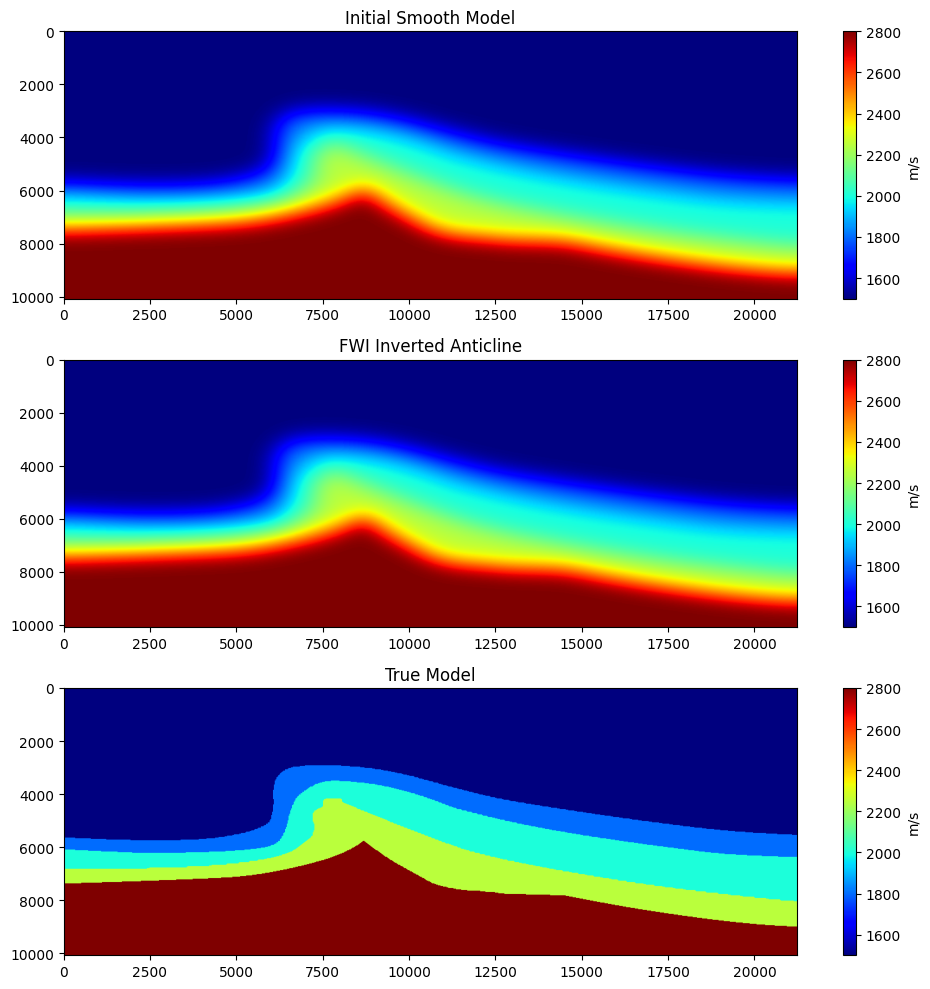

In [6]:
# 1. INSTALL LIBRARIES
!pip install deepwave

# 2. LIBRARIES AND SETTINGS
import numpy as np
import torch
import scipy.io
import gc
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import deepwave
from deepwave import scalar

# Device: GPU if available (T4 on Colab)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# 3. INPUT: ANTICLINE MODEL (.mat file)
mat_path = 'anticline_model.mat'

try:
    mat = scipy.io.loadmat(mat_path)
    v_true_np = None
    max_size = 0
    for key in mat:
        if isinstance(mat[key], np.ndarray):
            arr = np.squeeze(mat[key])
            if arr.ndim == 2 and arr.size > max_size:
                v_true_np = arr.astype(np.float32)
                max_size = arr.size

    if v_true_np is None:
        raise ValueError("Could not find a valid 2D velocity array.")

    if np.max(v_true_np) < 10: # Convert km/s to m/s
        v_true_np *= 1000.0
except FileNotFoundError:
    print(f"Error: {mat_path} not found.")
    raise

v_true = torch.from_numpy(v_true_np).to(device)
if v_true.shape[0] < v_true.shape[1]: v_true = v_true.T

nx, nz = v_true.shape
print(f"Model shape (nx, nz) = {nx} x {nz}")

dx, dz = 25.0, 25.0
spacing = (dx, dz)
extent = [0, (nx - 1) * dx, (nz - 1) * dz, 0]

# 4. INITIAL VELOCITY MODEL
v_init = (torch.tensor(1/gaussian_filter(1/v_true.cpu().numpy(), sigma=15)).to(device))
v1 = v_init.clone()
v1.requires_grad_()

vmin_plot, vmax_plot = v_true.min().item(), v_true.max().item()

# 5. ACQUISITION GEOMETRY
n_shots = 15 # Reduced shot count slightly to speed up inversion
n_sources_per_shot = 1
n_receivers_per_shot = nx
freq = 5.0
dt = 0.002
nt = 750 # REDUCED to save memory (1.5 seconds of recording)
peak_time = 1.5/freq

source_loc = torch.zeros(n_shots, n_sources_per_shot, 2, dtype=torch.long, device=device)
source_loc[..., 1] = 2
source_loc[:, 0, 0] = torch.linspace(0, nx - 1, n_shots).round()

receiver_loc = torch.zeros(n_shots, n_receivers_per_shot, 2, dtype=torch.long, device=device)
receiver_loc[..., 1] = 2
receiver_loc[:, :, 0] = torch.linspace(0, nx - 1, n_receivers_per_shot).round()

source_amp = (deepwave.wavelets.ricker(freq, nt, dt, peak_time)
              .repeat(n_shots, n_sources_per_shot, 1).to(device))

# 6. FORWARD MODELLING
print("Generating observed data...")
observed_data = torch.zeros(n_shots, n_receivers_per_shot, nt, device=device)

with torch.no_grad():
    for i in range(n_shots):
        out = scalar(v_true, spacing, dt,
                     source_amplitudes=source_amp[i:i+1],
                     source_locations=source_loc[i:i+1],
                     receiver_locations=receiver_loc[i:i+1],
                     accuracy=4, pml_freq=freq, pml_width=[20, 20, 20, 20])
        observed_data[i:i+1] = out[-1]
        torch.cuda.empty_cache()

# 7. INVERSION
def taper(x): return deepwave.common.cosine_taper_end(x, 15)
observed_data_tapered = taper(observed_data)
loss_fn = torch.nn.MSELoss()
optimiser = torch.optim.Adam([v1], lr=15.0)

print("Starting Inversion (Memory Optimized)...")
for epoch in range(400):
    optimiser.zero_grad()
    epoch_loss = 0

    # Process one shot at a time (Batch Size 1) to fit in 15GB VRAM
    for i in range(n_shots):
        out_pred = scalar(v1, spacing, dt,
                          source_amplitudes=source_amp[i:i+1],
                          source_locations=source_loc[i:i+1],
                          receiver_locations=receiver_loc[i:i+1],
                          accuracy=4, pml_freq=freq,
                          pml_width=[20, 20, 20, 20])

        loss = loss_fn(taper(out_pred[-1]), observed_data_tapered[i:i+1])
        loss = loss / n_shots
        loss.backward() # This is where memory peaks
        epoch_loss += loss.item()

        # Free memory from the forward pass result
        del out_pred
        torch.cuda.empty_cache()

    # Gradient Post-processing
    with torch.no_grad():
        grad_np = gaussian_filter(v1.grad.cpu().numpy(), sigma=1.5)
        v1.grad.copy_(torch.tensor(grad_np).to(device))
        v1.clamp_(min=vmin_plot, max=vmax_plot)

    optimiser.step()

    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1} | Loss: {epoch_loss:.6f}")
        gc.collect()

# 8. FINAL PLOTTING
fig, ax = plt.subplots(3, 1, figsize=(10, 10))
imgs = [v_init.cpu(), v1.detach().cpu(), v_true.cpu()]
titles = ["Initial Smooth Model", "FWI Inverted Anticline", "True Model"]

for i in range(3):
    im = ax[i].imshow(imgs[i].T, aspect='auto', cmap='jet', vmin=vmin_plot, vmax=vmax_plot, extent=extent)
    ax[i].set_title(titles[i])
    fig.colorbar(im, ax=ax[i], label='m/s')
plt.tight_layout()
plt.show()

Device: cuda
Generating data for 4.5 seconds...
Starting Full-Model Inversion...
Epoch 010 | Loss: 1.7389e-01
Epoch 020 | Loss: 4.5095e-02
Epoch 030 | Loss: 1.9675e-02
Epoch 040 | Loss: 9.8240e-03
Epoch 050 | Loss: 5.9308e-03
Epoch 060 | Loss: 4.1868e-03
Epoch 070 | Loss: 3.0433e-03
Epoch 080 | Loss: 2.3048e-03
Epoch 090 | Loss: 1.8645e-03
Epoch 100 | Loss: 1.5888e-03


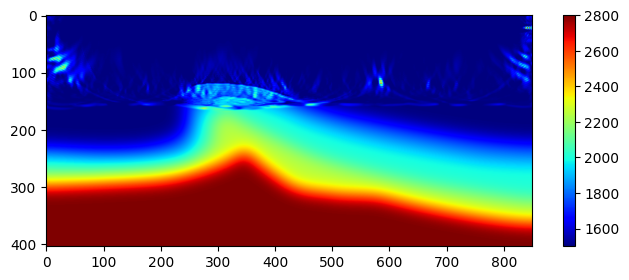

KeyboardInterrupt: 

In [15]:
import numpy as np
import torch
import scipy.io
import gc
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import deepwave
from deepwave import scalar

# 1. SETTINGS
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# 2. INPUT: ANTICLINE MODEL
mat_path = 'anticline_model.mat'
try:
    mat = scipy.io.loadmat(mat_path)
    v_true_np = None
    for key in mat:
        if isinstance(mat[key], np.ndarray):
            arr = np.squeeze(mat[key])
            if arr.ndim == 2:
                v_true_np = arr.astype(np.float32)
                break
    if v_true_np is None: raise ValueError("Invalid 2D array.")
    if np.max(v_true_np) < 10: v_true_np *= 1000.0
except:
    v_true_np = 2000 * np.ones((850, 404), dtype=np.float32)
    v_true_np[:, 250:] = 3500 # Deep layer

v_true = torch.from_numpy(v_true_np).to(device)
if v_true.shape[0] < v_true.shape[1]: v_true = v_true.T
nx, nz = v_true.shape

# 3. INITIAL MODEL
v_init_np = 1/gaussian_filter(1/v_true.cpu().numpy(), sigma=15)
v_init = torch.from_numpy(v_init_np).to(device)
v1 = v_init.clone().requires_grad_(True)
vmin, vmax = v_true.min().item(), v_true.max().item()

# 4. GEOMETRY (Optimized for Depth)
pml_v = 20
dx, dz = 25.0, 25.0
spacing = (dx, dz)
dt = 0.003  # Increased dt slightly to allow longer time without OOM
nt = 1500   # INCREASED: 1500 * 0.003 = 4.5 seconds (Enough to see deeper layers)
freq = 5.0
n_shots = 15

rx = torch.arange(pml_v, nx - pml_v, device=device)
n_receivers_per_shot = len(rx)

source_loc = torch.zeros(n_shots, 1, 2, dtype=torch.long, device=device)
source_loc[..., 1] = pml_v + 2
source_loc[:, 0, 0] = torch.linspace(pml_v, nx - pml_v, n_shots).to(torch.long)

receiver_loc = torch.zeros(n_shots, n_receivers_per_shot, 2, dtype=torch.long, device=device)
receiver_loc[..., 1] = pml_v + 2
for i in range(n_shots): receiver_loc[i, :, 0] = rx

source_amp = deepwave.wavelets.ricker(freq, nt, dt, 1.5/freq).repeat(n_shots, 1, 1).to(device)

# 5. GENERATE OBSERVED DATA
print(f"Generating data for {nt*dt} seconds...")
observed_data = torch.zeros(n_shots, n_receivers_per_shot, nt, device=device)
with torch.no_grad():
    for i in range(n_shots):
        out = scalar(v_true, spacing, dt, source_amplitudes=source_amp[i:i+1],
                     source_locations=source_loc[i:i+1], receiver_locations=receiver_loc[i:i+1],
                     pml_width=[pml_v]*4, pml_freq=freq)
        observed_data[i] = out[-1]

initial_loss = 0
with torch.no_grad():
    for i in range(n_shots):
        out_init = scalar(v1, spacing, dt, source_amplitudes=source_amp[i:i+1],
                          source_locations=source_loc[i:i+1], receiver_locations=receiver_loc[i:i+1],
                          pml_width=[pml_v]*4, pml_freq=freq)
        initial_loss += torch.nn.MSELoss()(out_init[-1], observed_data[i:i+1]).item()

# 6. DEPTH PRECONDITIONING (THE KEY TO DEEP INVERSION)
# Create a gain that increases with depth to boost deep gradients
z_gain = torch.linspace(1.0, 5.0, nz, device=device).view(1, nz)

# 7. INVERSION
optimizer = torch.optim.Adam([v1], lr=35.0)
loss_history = []

print("Starting Full-Model Inversion...")
for epoch in range(400):
    optimizer.zero_grad()
    epoch_loss = 0
    for i in range(n_shots):
        out_pred = scalar(v1, spacing, dt, source_amplitudes=source_amp[i:i+1],
                          source_locations=source_loc[i:i+1], receiver_locations=receiver_loc[i:i+1],
                          pml_width=[pml_v]*4, pml_freq=freq)
        loss = torch.nn.MSELoss()(out_pred[-1], observed_data[i:i+1])
        (loss / (initial_loss / n_shots)).backward()
        epoch_loss += loss.item()
        del out_pred

    # Gradient Processing
    with torch.no_grad():
        if v1.grad is not None:
            # 1. Apply depth gain to force updates at the bottom
            v1.grad *= z_gain

            # 2. Smooth gradient
            grad = gaussian_filter(v1.grad.cpu().numpy(), sigma=2.0)
            v1.grad.copy_(torch.from_numpy(grad).to(device))

            # 3. Update and Clamp
            optimizer.step()
            v1.clamp_(min=vmin, max=vmax)

    loss_history.append(epoch_loss)
    if (epoch + 1) % 10 == 0: print(f"Epoch {epoch+1:03d} | Loss: {epoch_loss:.4e}")
    if (epoch + 1) % 100 == 0:
        plt.figure(figsize=(8,3)); plt.imshow(v1.detach().cpu().numpy().T, cmap='jet'); plt.colorbar(); plt.show()
        gc.collect(); torch.cuda.empty_cache()

# 8. FINAL PLOTS
fig, ax = plt.subplots(3, 1, figsize=(10, 12))
imgs = [v_init.cpu().numpy(), v1.detach().cpu().numpy(), v_true.cpu().numpy()]
titles = ["Initial (Smooth)", "Final (Inverted Top-to-Bottom)", "True Model"]
for i in range(3):
    im = ax[i].imshow(imgs[i].T, aspect='auto', cmap='jet', vmin=vmin, vmax=vmax, extent=[0, nx*dx, nz*dz, 0])
    ax[i].set_title(titles[i]); fig.colorbar(im, ax=ax[i], label='m/s')
plt.tight_layout(); plt.show()

Device: cuda
Generating data for 7.5 seconds (Deep Illumination)...
Starting Top-to-Bottom Inversion...
Epoch 010 | Norm Loss: 13.1283


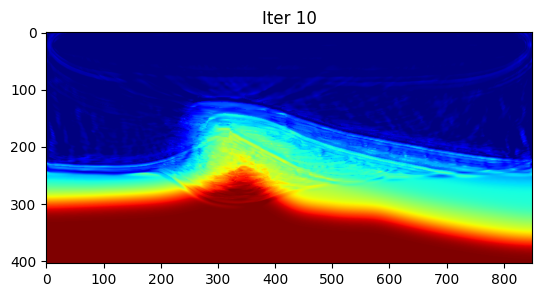

KeyboardInterrupt: 

In [16]:
import numpy as np
import torch
import scipy.io
import gc
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import deepwave
from deepwave import scalar

# 1. SETTINGS
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# 2. INPUT: ANTICLINE MODEL
mat_path = 'anticline_model.mat'
try:
    mat = scipy.io.loadmat(mat_path)
    v_true_np = None
    for key in mat:
        if isinstance(mat[key], np.ndarray):
            arr = np.squeeze(mat[key])
            if arr.ndim == 2:
                v_true_np = arr.astype(np.float32)
                break
    if v_true_np is None: raise ValueError("Invalid 2D array.")
    if np.max(v_true_np) < 10: v_true_np *= 1000.0
except:
    v_true_np = 2000 * np.ones((850, 404), dtype=np.float32)
    v_true_np[:, 200:] = 3500

v_true = torch.from_numpy(v_true_np).to(device)
if v_true.shape[0] < v_true.shape[1]: v_true = v_true.T
nx, nz = v_true.shape

# 3. INITIAL MODEL
v_init_np = 1/gaussian_filter(1/v_true.cpu().numpy(), sigma=15)
v_init = torch.from_numpy(v_init_np).to(device)
v1 = v_init.clone().requires_grad_(True)
vmin, vmax = v_true.min().item(), v_true.max().item()

# 4. GEOMETRY (CRITICAL FOR DEPTH)
pml_v = 20
dx, dz = 25.0, 25.0
spacing = (dx, dz)
dt = 0.003
nt = 2500   # 2500 * 0.003 = 7.5 SECONDS. Essential to reach 10km depth.
freq = 5.0
n_shots = 12 # Fewer shots to save memory for the long time duration

rx = torch.arange(pml_v, nx - pml_v, device=device)
n_receivers_per_shot = len(rx)

source_loc = torch.zeros(n_shots, 1, 2, dtype=torch.long, device=device)
source_loc[..., 1] = pml_v + 2
source_loc[:, 0, 0] = torch.linspace(pml_v, nx - pml_v, n_shots).to(torch.long)

receiver_loc = torch.zeros(n_shots, n_receivers_per_shot, 2, dtype=torch.long, device=device)
receiver_loc[..., 1] = pml_v + 2
for i in range(n_shots): receiver_loc[i, :, 0] = rx

source_amp = deepwave.wavelets.ricker(freq, nt, dt, 1.5/freq).repeat(n_shots, 1, 1).to(device)

# 5. GENERATE DATA
print(f"Generating data for {nt*dt} seconds (Deep Illumination)...")
observed_data = torch.zeros(n_shots, n_receivers_per_shot, nt, device=device)
with torch.no_grad():
    for i in range(n_shots):
        out = scalar(v_true, spacing, dt, source_amplitudes=source_amp[i:i+1],
                     source_locations=source_loc[i:i+1], receiver_locations=receiver_loc[i:i+1],
                     pml_width=[pml_v]*4, pml_freq=freq)
        observed_data[i] = out[-1]

# Pre-calculate initial loss for normalization
with torch.no_grad():
    initial_loss = 0
    for i in range(n_shots):
        out_init = scalar(v1, spacing, dt, source_amplitudes=source_amp[i:i+1],
                          source_locations=source_loc[i:i+1], receiver_locations=receiver_loc[i:i+1],
                          pml_width=[pml_v]*4, pml_freq=freq)
        initial_loss += torch.nn.MSELoss()(out_init[-1], observed_data[i:i+1]).item()
    initial_loss /= n_shots

# 6. DEPTH PRECONDITIONING
# We use a quadratic gain (z^2) to boost deep gradients significantly
z = torch.linspace(0, 1, nz, device=device)
z_gain = (1.0 + 10.0 * z**2).view(1, nz) # 1x at surface, 11x at bottom

# 7. INVERSION
optimizer = torch.optim.Adam([v1], lr=40.0) # High LR for deep structures
loss_history = []

print("Starting Top-to-Bottom Inversion...")
for epoch in range(400):
    optimizer.zero_grad()
    epoch_loss = 0

    for i in range(n_shots):
        out_pred = scalar(v1, spacing, dt, source_amplitudes=source_amp[i:i+1],
                          source_locations=source_loc[i:i+1], receiver_locations=receiver_loc[i:i+1],
                          pml_width=[pml_v]*4, pml_freq=freq)

        loss = torch.nn.MSELoss()(out_pred[-1], observed_data[i:i+1])
        (loss / initial_loss).backward()
        epoch_loss += (loss / initial_loss).item()
        del out_pred

    # Process Gradient
    with torch.no_grad():
        if v1.grad is not None:
            v1.grad *= z_gain # Boost deep updates
            grad = gaussian_filter(v1.grad.cpu().numpy(), sigma=2.5)
            v1.grad.copy_(torch.from_numpy(grad).to(device))
            optimizer.step()
            v1.clamp_(min=vmin, max=vmax)

    loss_history.append(epoch_loss)
    if (epoch + 1) % 10 == 0: print(f"Epoch {epoch+1:03d} | Norm Loss: {epoch_loss:.4f}")
    if (epoch + 1) % 50 == 0:
        plt.figure(figsize=(8,3)); plt.imshow(v1.detach().cpu().numpy().T, cmap='jet'); plt.title(f"Iter {epoch+1}"); plt.show()
        gc.collect(); torch.cuda.empty_cache()

# 8. FINAL PLOTS
fig, ax = plt.subplots(3, 1, figsize=(10, 12))
imgs = [v_init.cpu().numpy(), v1.detach().cpu().numpy(), v_true.cpu().numpy()]
titles = ["Initial Smooth", "FWI Final (Full Depth)", "True Model"]
for i in range(3):
    im = ax[i].imshow(imgs[i].T, aspect='auto', cmap='jet', vmin=vmin, vmax=vmax, extent=[0, nx*dx, nz*dz, 0])
    ax[i].set_title(titles[i]); fig.colorbar(im, ax=ax[i], label='m/s')
plt.tight_layout(); plt.show()

In [ ]:
import numpy as np
import torch
import scipy.io
import gc
import os
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import deepwave
from deepwave import scalar

# 1. DEVICE & MEMORY CONFIG
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Prevent fragmentation
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
print(f"Using device: {device}")

# 2. MODEL PREPARATION
try:
    mat = scipy.io.loadmat('anticline_model.mat')
    v_true_np = None
    for key in mat:
        if isinstance(mat[key], np.ndarray):
            arr = np.squeeze(mat[key])
            if arr.ndim == 2:
                v_true_np = arr.astype(np.float32)
                break
    if v_true_np is None: raise ValueError
except:
    v_true_np = 2000 * np.ones((400, 500), dtype=np.float32)
    v_true_np[:, 250:] = 3500
    v_true_np[150:250, 180:320] = 4500

v_true = torch.from_numpy(v_true_np).to(device)
nx, nz = v_true.shape
vmin, vmax = v_true.min().item(), v_true.max().item()

# 3. INITIAL MODEL
v_init_np = 1/gaussian_filter(1/v_true.cpu().numpy(), sigma=15)
v_init = torch.from_numpy(v_init_np).to(device)
v1 = v_init.clone().requires_grad_(True)

# 4. GEOMETRY (8 SECONDS & FULL ILLUMINATION)
dx, dz = 20.0, 20.0
spacing = (dx, dz)
dt = 0.003
nt = 2667   # 8.001 seconds
freq = 5.0
pml_v = 20
n_shots = 8 # Reduced number of shots to ensure memory stability on T4

# FIX: Spread sources across the FULL horizontal extent for right-side illumination
source_loc = torch.zeros(n_shots, 1, 2, dtype=torch.long, device=device)
source_loc[..., 1] = 2
source_loc[:, 0, 0] = torch.linspace(0, nx - 1, n_shots).to(torch.long)

# FIX: Spread receivers across the FULL width
rx = torch.arange(0, nx, 2, device=device)
n_receivers_per_shot = len(rx)
receiver_loc = torch.zeros(n_shots, n_receivers_per_shot, 2, dtype=torch.long, device=device)
receiver_loc[..., 1] = 2
for i in range(n_shots):
    receiver_loc[i, :, 0] = rx

# Store Wavelet on CPU to save GPU RAM
source_amp_cpu = deepwave.wavelets.ricker(freq, nt, dt, 1.5/freq).repeat(n_shots, 1, 1)

# 5. GENERATE DATA (Forward modeling)
print(f"Generating data for {nt*dt:.2f}s...")
# Store observed data on CPU to keep GPU free for inversion buffers
observed_data_cpu = torch.zeros(n_shots, n_receivers_per_shot, nt)

with torch.no_grad():
    for i in range(n_shots):
        out = scalar(v_true, spacing, dt,
                     source_amplitudes=source_amp_cpu[i:i+1].to(device),
                     source_locations=source_loc[i:i+1],
                     receiver_locations=receiver_loc[i:i+1],
                     pml_width=[pml_v]*4, pml_freq=freq)
        observed_data_cpu[i] = out[-1].cpu()
        del out
        torch.cuda.empty_cache()

# Move v_true to CPU now to free up space (only keep v1 on GPU)
v_true_cpu = v_true.cpu().numpy()
# del v_true # Uncomment if memory is still tight

# 6. INVERSION SETUP
optimizer = torch.optim.Adam([v1], lr=15.0)
# FIX: Scheduler ensures loss keeps decreasing even after 100 epochs
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=15)

# Depth preconditioning (z^2 gain)
z = torch.linspace(0, 1, nz, device=device)
z_gain = (1.0 + 25.0 * z**2).view(1, nz)

loss_history = []

# 7. INVERSION LOOP
print("Starting Inversion (8s Duration - T4 Optimized)...")

for epoch in range(400):
    optimizer.zero_grad(set_to_none=True)
    epoch_loss = 0

    for i in range(n_shots):
        # Move only the current shot to GPU
        curr_source_amp = source_amp_cpu[i:i+1].to(device)
        curr_observed = observed_data_cpu[i:i+1].to(device)

        out_pred = scalar(v1, spacing, dt,
                          source_amplitudes=curr_source_amp,
                          source_locations=source_loc[i:i+1],
                          receiver_locations=receiver_loc[i:i+1],
                          pml_width=[pml_v]*4,
                          pml_freq=freq)

        loss = torch.nn.MSELoss()(out_pred[-1], curr_observed)
        loss.backward()

        epoch_loss += loss.item()

        # CLEANUP IMMEDIATELY AFTER EVERY SHOT
        del out_pred, curr_observed, curr_source_amp
        torch.cuda.synchronize() # Force GPU to finish tasks
        torch.cuda.empty_cache()
        gc.collect()

    # Apply Gradient Preconditioning
    with torch.no_grad():
        if v1.grad is not None:
            v1.grad *= z_gain
            grad_smooth = gaussian_filter(v1.grad.cpu().numpy(), sigma=2.0)
            v1.grad.copy_(torch.from_numpy(grad_smooth).to(device))

            optimizer.step()
            v1.clamp_(min=vmin, max=vmax)

    # Update scheduler
    scheduler.step(epoch_loss)
    loss_history.append(epoch_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1:03d} | Loss: {epoch_loss:.6f} | LR: {optimizer.param_groups[0]['lr']:.4f}")

    # Plot side-by-side every 50 iterations
    if (epoch + 1) % 50 == 0:
        fig, ax = plt.subplots(1, 2, figsize=(15, 4))
        ax[0].imshow(v_true_cpu.T, cmap='jet', vmin=vmin, vmax=vmax, aspect='auto')
        ax[0].set_title("True Model")
        im = ax[1].imshow(v1.detach().cpu().numpy().T, cmap='jet', vmin=vmin, vmax=vmax, aspect='auto')
        ax[1].set_title(f"Inverted Model (Epoch {epoch+1})")
        plt.colorbar(im, ax=ax[1])
        plt.show()

# 8. CONVERGENCE PLOT
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(loss_history)+1), loss_history, color='blue', lw=2)
plt.title("FWI Convergence (Should be strictly decreasing/stable)", fontsize=14)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.yscale('log')
plt.grid(True, which="both", alpha=0.3)
plt.show()

# 9. FINAL RESULT
fig, ax = plt.subplots(3, 1, figsize=(12, 12))
imgs = [v_init.cpu().numpy(), v1.detach().cpu().numpy(), v_true_cpu]
titles = ["Initial Smooth Model", "Final Inverted (8s + Full Illumination)", "True Model"]
for i in range(3):
    im = ax[i].imshow(imgs[i].T, aspect='auto', cmap='jet', vmin=vmin, vmax=vmax, extent=[0, nx*dx, nz*dz, 0])
    ax[i].set_title(titles[i])
    fig.colorbar(im, ax=ax[i], label='m/s')
plt.tight_layout()
plt.show()

Using device: cuda
Generating data for 8.00s...
Starting Inversion (8s Duration - T4 Optimized)...
